In [1]:
from sklearn.metrics import confusion_matrix
import pylab as pl
import numpy as np
import matplotlib.colors as mcolors

In [2]:
with open("res/expectedDT.txt", "r") as file:
    expected = [int(line.strip()) for line in file]

with open("res/predictedDT.txt", "r") as file:
    predicted = [int(line.strip()) for line in file]

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(expected, predicted))
print("Precision:", precision_score(expected, predicted))
print("Recall:", recall_score(expected, predicted))
print("F1 Score:", f1_score(expected, predicted))

Accuracy: 0.8112155662439877
Precision: 0.7759927363018141
Recall: 0.9238065825465455
F1 Score: 0.8434727439349843


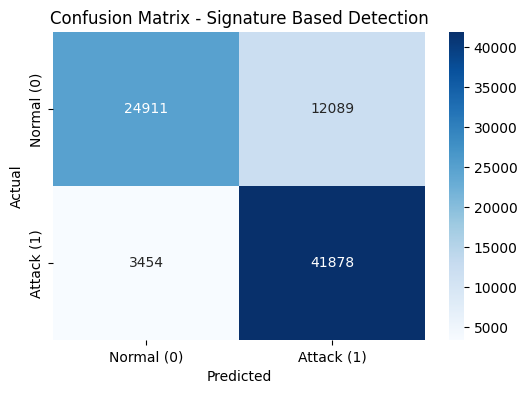

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(expected, predicted)
labels = ['Normal (0)', 'Attack (1)']

# Display heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Signature Based Detection')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

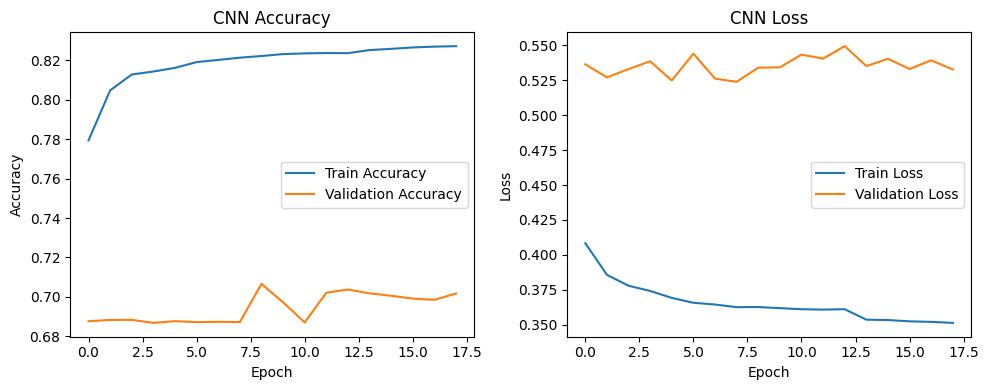

In [5]:
import pandas as pd

# Load CSV data
cnn_data = pd.read_csv("results/cnn3results/cnntrainanalysis1.csv")

# Plot accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(cnn_data['epoch'], cnn_data['accuracy'], label='Train Accuracy')
plt.plot(cnn_data['epoch'], cnn_data['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1,2,2)
plt.plot(cnn_data['epoch'], cnn_data['loss'], label='Train Loss')
plt.plot(cnn_data['epoch'], cnn_data['val_loss'], label='Validation Loss')
plt.title('CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Simulated Streaming IDS Demo:
---------------------------------
Event 01: Signature=0, Anomaly=1, CNN=1 -> Final Decision: Attack
Event 02: Signature=0, Anomaly=1, CNN=0 -> Final Decision: Normal
Event 03: Signature=0, Anomaly=0, CNN=0 -> Final Decision: Normal
Event 04: Signature=0, Anomaly=1, CNN=0 -> Final Decision: Normal
Event 05: Signature=0, Anomaly=1, CNN=1 -> Final Decision: Attack
Event 06: Signature=0, Anomaly=0, CNN=1 -> Final Decision: Normal
Event 07: Signature=1, Anomaly=1, CNN=0 -> Final Decision: Attack
Event 08: Signature=0, Anomaly=0, CNN=1 -> Final Decision: Normal
Event 09: Signature=0, Anomaly=1, CNN=1 -> Final Decision: Attack
Event 10: Signature=1, Anomaly=1, CNN=0 -> Final Decision: Attack
Event 11: Signature=1, Anomaly=1, CNN=0 -> Final Decision: Attack
Event 12: Signature=1, Anomaly=0, CNN=0 -> Final Decision: Normal
Event 13: Signature=1, Anomaly=0, CNN=1 -> Final Decision: Attack
Event 14: Signature=1, Anomaly=1, CNN=1 -> Final Decision: Attack
Event 15: Si

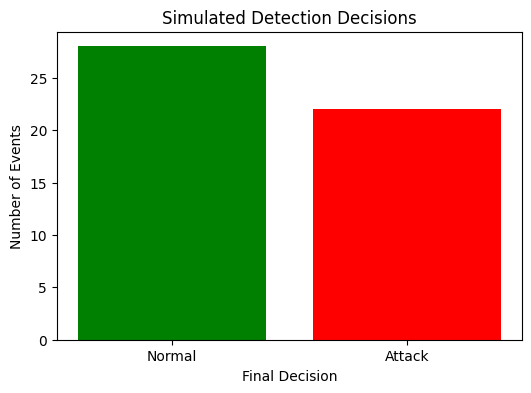

In [6]:
import time
import random
import pandas as pd
import matplotlib.pyplot as plt

# Simulate a small test dataset of network events (for demo purposes)
n_events = 50
data = pd.DataFrame({
    'feature1': [random.random() for _ in range(n_events)],
    'feature2': [random.random() for _ in range(n_events)],
    # Add additional simulated features as needed
})

results = []  # Store aggregated decisions for each event

print("Simulated Streaming IDS Demo:")
print("---------------------------------")
# Simulate processing of incoming events
for index, row in data.iterrows():
    time.sleep(0.1)  # Simulate time delay for real-time processing
    
    # Here we simulate each detector's decision:
    # In your actual system, you would use: 
    #   sig_decision = signature_model.predict(row_features)
    #   anom_decision = anomaly_model.predict(row_features)
    #   cnn_decision = cnn_model.predict(row_features)
    #
    # For this demo, we choose randomly:
    sig_decision = random.choice([0, 1])  # 0 = Normal, 1 = Attack
    anom_decision = random.choice([0, 1])
    cnn_decision = random.choice([0, 1])
    
    # Aggregate decision (for example, majority vote)
    vote_sum = sig_decision + anom_decision + cnn_decision
    final_decision = 1 if vote_sum >= 2 else 0
    
    results.append(final_decision)
    
    # Print simulated log entry
    print(f"Event {index+1:02d}: Signature={sig_decision}, Anomaly={anom_decision}, CNN={cnn_decision} -> Final Decision: {'Attack' if final_decision == 1 else 'Normal'}")

# Display a summary bar chart of the decisions
plt.figure(figsize=(6,4))
plt.bar(["Normal", "Attack"], [results.count(0), results.count(1)], color=['green', 'red'])
plt.title("Simulated Detection Decisions")
plt.xlabel("Final Decision")
plt.ylabel("Number of Events")
plt.show()


In [1]:
import sys
import random
import numpy as np
import pandas as pd
from datetime import datetime
from collections import deque
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from PyQt5.QtWidgets import (QApplication, QMainWindow, QWidget, QVBoxLayout,
                             QPushButton, QTabWidget, QTextEdit, QHBoxLayout, 
                             QLabel, QSlider, QMessageBox, QComboBox, QGridLayout,
                             QGroupBox, QTableWidget, QTableWidgetItem, QHeaderView, QFileDialog)
from PyQt5.QtCore import QTimer, Qt, pyqtSignal
from PyQt5.QtGui import QColor
import pyqtgraph as pg
import scapy.all as scapy


class PacketCapture:
    """Class to handle packet capture and feature extraction"""
    def __init__(self, interface=None, use_sample_data=True):
        self.interface = interface
        self.use_sample_data = use_sample_data
        self.packet_buffer = deque(maxlen=100)
        self.scaler = StandardScaler()
        
        # For sample data mode
        self.normal_patterns = [
            {'protocol': 'TCP', 'port': 80, 'size': 64, 'flags': 'A'},
            {'protocol': 'TCP', 'port': 443, 'size': 128, 'flags': 'PA'},
            {'protocol': 'UDP', 'port': 53, 'size': 32, 'flags': None},
            {'protocol': 'ICMP', 'port': None, 'size': 84, 'flags': None}
        ]
        self.attack_patterns = [
            {'protocol': 'TCP', 'port': 22, 'size': 60, 'flags': 'S', 'type': 'Port Scan'},
            {'protocol': 'TCP', 'port': 80, 'size': 1500, 'flags': 'A', 'type': 'DDoS'},
            {'protocol': 'TCP', 'port': 445, 'size': 48, 'flags': 'S', 'type': 'Lateral Movement'},
            {'protocol': 'UDP', 'port': 1900, 'size': 600, 'flags': None, 'type': 'Amplification'}
        ]
        self.attack_probability = 0.15  # 15% chance for attack packet
    
    def get_next_packet(self):
        """Generate or capture a new packet and extract features"""
        if self.use_sample_data:
            return self._generate_sample_packet()
        else:
            # Implement real packet capture with scapy
            try:
                packets = scapy.sniff(count=1, timeout=0.5, iface=self.interface)
                if packets:
                    return self._extract_features(packets[0])
                else:
                    return self._generate_sample_packet()  # Fallback
            except Exception as e:
                print(f"Packet capture error: {e}")
                return self._generate_sample_packet()  # Fallback
    
    def _generate_sample_packet(self):
        """Generate a simulated packet with realistic features"""
        is_attack = random.random() < self.attack_probability
        
        if is_attack:
            pattern = random.choice(self.attack_patterns)
            attack_type = pattern['type']
        else:
            pattern = random.choice(self.normal_patterns)
            attack_type = None
            
        # Add some noise to make it more realistic
        size_noise = random.randint(-20, 20)
        
        # Generate source and destination IPs
        if is_attack and random.random() < 0.7:  # Most attacks from external IPs
            src_ip = f"192.168.{random.randint(1,5)}.{random.randint(1,254)}" if random.random() < 0.3 else f"{random.randint(1,223)}.{random.randint(0,255)}.{random.randint(0,255)}.{random.randint(1,254)}"
            dst_ip = f"192.168.1.{random.randint(1,20)}"  # Internal network
        else:
            # Normal traffic - mix of internal and external
            if random.random() < 0.5:  # Internal to external
                src_ip = f"192.168.1.{random.randint(1,20)}"
                dst_ip = f"{random.randint(1,223)}.{random.randint(0,255)}.{random.randint(0,255)}.{random.randint(1,254)}"
            else:  # Internal to internal
                src_ip = f"192.168.1.{random.randint(1,20)}"
                dst_ip = f"192.168.1.{random.randint(1,20)}"
                
        timestamp = datetime.now()
        
        # Calculate feature vector for models
        protocol_num = {'TCP': 6, 'UDP': 17, 'ICMP': 1}.get(pattern['protocol'], 0)
        port = pattern['port'] if pattern['port'] else 0
        size = pattern['size'] + size_noise
        
        # Create feature dictionary
        features = {
            'timestamp': timestamp,
            'src_ip': src_ip,
            'dst_ip': dst_ip,
            'protocol': pattern['protocol'],
            'protocol_num': protocol_num,
            'dst_port': port,
            'size': size,
            'flags': pattern['flags'],
            'attack': 1 if is_attack else 0,
            'attack_type': attack_type
        }
        
        # Add to packet buffer
        self.packet_buffer.append(features)
        
        return features
    
    def _extract_features(self, packet):
        """Extract features from a real packet captured with scapy"""
        features = {
            'timestamp': datetime.now(),
            'src_ip': None,
            'dst_ip': None,
            'protocol': None,
            'protocol_num': 0,
            'dst_port': 0,
            'size': len(packet),
            'flags': None,
            'attack': 0,  # Unknown, to be determined by models
            'attack_type': None
        }
        
        if scapy.IP in packet:
            features['src_ip'] = packet[scapy.IP].src
            features['dst_ip'] = packet[scapy.IP].dst
            features['protocol_num'] = packet[scapy.IP].proto
            
            if scapy.TCP in packet:
                features['protocol'] = 'TCP'
                features['dst_port'] = packet[scapy.TCP].dport
                features['flags'] = str(packet[scapy.TCP].flags)
            elif scapy.UDP in packet:
                features['protocol'] = 'UDP'
                features['dst_port'] = packet[scapy.UDP].dport
            elif scapy.ICMP in packet:
                features['protocol'] = 'ICMP'
        
        # Add to packet buffer
        self.packet_buffer.append(features)
        
        return features
    
    def get_feature_vector(self, features):
        """Convert features dictionary to numerical vector for model input"""
        vector = [
            features['protocol_num'],
            features['dst_port'],
            features['size'],
            # Add more numerical features
        ]
        return np.array(vector).reshape(1, -1)


class IDSModels:
    """Class to manage the various detection models"""
    def __init__(self):
        # Initialize models
        self.signature_model = RandomForestClassifier(n_estimators=50)
        self.anomaly_model = IsolationForest(contamination=0.1)
        self.cnn_model = None  # Placeholder for deep learning model
        
        # Features for model training
        self.signature_features = []
        self.signature_labels = []
        
        # Load/train initial models with sample data
        self._initialize_models()
    
    def _initialize_models(self):
        """Initialize models with sample training data"""
        # Generate sample training data
        X_train = []
        y_train = []
        
        # Generate normal traffic samples
        for _ in range(100):
            protocol = random.choice([6, 17, 1])  # TCP, UDP, ICMP
            port = random.choice([80, 443, 53, 0]) if protocol != 1 else 0
            size = random.randint(32, 200)
            X_train.append([protocol, port, size])
            y_train.append(0)
        
        # Generate attack traffic samples
        for _ in range(20):
            protocol = 6  # Mostly TCP
            port = random.choice([22, 445, 3389, 25])
            size = random.choice([40, 1500])
            X_train.append([protocol, port, size])
            y_train.append(1)
        
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        
        # Train signature model
        self.signature_model.fit(X_train, y_train)
        
        # Train anomaly model (only on normal data)
        X_normal = X_train[y_train == 0]
        self.anomaly_model.fit(X_normal)
    
    def predict(self, feature_vector):
        """Make predictions using all models"""
        # Signature-based detection
        sig_prediction = int(self.signature_model.predict(feature_vector)[0])
        
        # Anomaly-based detection (convert to binary: -1 = anomaly, 1 = normal)
        anom_score = self.anomaly_model.decision_function(feature_vector)[0]
        anom_prediction = 1 if anom_score < -0.2 else 0
        
        # CNN-based detection (placeholder)
        cnn_prediction = 1 if random.random() < 0.1 + (sig_prediction * 0.1) + (anom_prediction * 0.1) else 0
        
        # Majority vote for final decision
        votes = sig_prediction + anom_prediction + cnn_prediction
        final_decision = 1 if votes >= 2 else 0
        
        return {
            'signature': sig_prediction,
            'anomaly': anom_prediction,
            'cnn': cnn_prediction,
            'final': final_decision
        }


class SimulationWindow(QMainWindow):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("Advanced IoT IDS Simulation")
        self.resize(1200, 800)
        self.simulation_speed = 500  # initial update interval in ms

        # Setup models and packet capture
        self.packet_capture = PacketCapture(use_sample_data=True)
        self.ids_models = IDSModels()
        
        # Event storage and statistics
        self.events = []  # each event is a dict with packet features and model decisions
        self.event_count = 0
        self.attack_count = 0
        self.total_packets = 0
        
        # Setup UI
        self._setup_ui()
        
        # Timer for simulation
        self.timer = QTimer()
        self.timer.timeout.connect(self.update_simulation)

    def _setup_ui(self):
        # Create main widget and layout
        self.main_widget = QWidget()
        self.main_layout = QVBoxLayout(self.main_widget)
        self.setCentralWidget(self.main_widget)

        # Create dashboard at the top
        self._setup_dashboard()

        # Create a tab widget for multiple views
        self.tabs = QTabWidget()
        self.main_layout.addWidget(self.tabs)

        # Visualization Tab with a scatter plot
        self._setup_visualization_tab()
        
        # Logs Tab with a scrolling text area and more structured view
        self._setup_logs_tab()
        
        # Statistics Tab
        self._setup_statistics_tab()
        
        # Settings Tab
        self._setup_settings_tab()

        # Control panel at the bottom
        self._setup_control_panel()

    def _setup_dashboard(self):
        dashboard = QGroupBox("IDS Dashboard")
        dashboard_layout = QGridLayout()
        dashboard.setLayout(dashboard_layout)
        
        # Status indicators
        self.status_label = QLabel("Status: Idle")
        self.status_label.setStyleSheet("font-weight: bold;")
        dashboard_layout.addWidget(self.status_label, 0, 0)
        
        # Packet counters
        self.packet_counter = QLabel("Total Packets: 0")
        dashboard_layout.addWidget(self.packet_counter, 0, 1)
        
        self.alert_counter = QLabel("Alerts: 0")
        dashboard_layout.addWidget(self.alert_counter, 0, 2)
        
        # Last alert
        self.last_alert = QLabel("Last Alert: None")
        dashboard_layout.addWidget(self.last_alert, 1, 0, 1, 3)
        
        # Add dashboard to main layout
        self.main_layout.addWidget(dashboard)

    def _setup_visualization_tab(self):
        self.visualization_tab = QWidget()
        self.vis_layout = QVBoxLayout(self.visualization_tab)
        
        # Use dark background for better visualization
        pg.setConfigOption('background', 'k')
        pg.setConfigOption('foreground', 'w')
        
        self.plotWidget = pg.PlotWidget(title="Real-Time Network Traffic Analysis")
        self.plotWidget.setXRange(0, 100)
        self.plotWidget.setYRange(0, 100)
        self.plotWidget.setLabel('left', "Size (bytes)")
        self.plotWidget.setLabel('bottom', "Port")
        
        self.scatter = pg.ScatterPlotItem(size=10, pen=pg.mkPen(None))
        self.plotWidget.addItem(self.scatter)
        
        # Add color legend
        self.legend = pg.LegendItem()
        self.legend.setParentItem(self.plotWidget.graphicsItem())
        self.legend.anchor((1, 0), (1, 0))
        
        # Create scatter items for legend
        normal_dot = pg.ScatterPlotItem(size=10, pen=pg.mkPen(None), brush=pg.mkBrush(0, 255, 0, 200))
        attack_dot = pg.ScatterPlotItem(size=10, pen=pg.mkPen(None), brush=pg.mkBrush(255, 0, 0, 200))
        
        self.legend.addItem(normal_dot, "Normal Traffic")
        self.legend.addItem(attack_dot, "Attack Traffic")
        
        self.vis_layout.addWidget(self.plotWidget)
        
        # Connect click signal
        self.plotWidget.scene().sigMouseClicked.connect(self.on_scene_mouse_clicked)
        
        self.tabs.addTab(self.visualization_tab, "Visualization")

    def _setup_logs_tab(self):
        self.logs_tab = QWidget()
        self.log_layout = QVBoxLayout(self.logs_tab)
        
        # Text log area
        self.logText = QTextEdit(readOnly=True)
        self.log_layout.addWidget(self.logText)
        
        # Add a table for structured view of events
        self.eventTable = QTableWidget(0, 7)
        self.eventTable.setHorizontalHeaderLabels([
            "Time", "Event ID", "Source IP", "Destination IP", 
            "Protocol", "Port", "Decision"
        ])
        self.eventTable.horizontalHeader().setSectionResizeMode(QHeaderView.Stretch)
        self.eventTable.setAlternatingRowColors(True)
        self.log_layout.addWidget(self.eventTable)
        
        self.tabs.addTab(self.logs_tab, "Event Logs")

    def _setup_statistics_tab(self):
        self.stats_tab = QWidget()
        self.stats_layout = QVBoxLayout(self.stats_tab)
        
        # Time series plot for attack trends
        self.timePlot = pg.PlotWidget(title="Attack Trends Over Time")
        self.timePlot.setLabel('left', "Attack Count")
        self.timePlot.setLabel('bottom', "Time (seconds)")
        self.timeLine = self.timePlot.plot(pen='y')
        self.stats_layout.addWidget(self.timePlot)
        
        # Bar graph for different attack types
        self.typePlot = pg.PlotWidget(title="Attack Types Distribution")
        self.typePlot.setLabel('left', "Count")
        self.typePlot.setLabel('bottom', "Attack Type")
        self.typeBar = pg.BarGraphItem(x=[1, 2, 3, 4], height=[0, 0, 0, 0], width=0.6, brush='r')
        self.typePlot.addItem(self.typeBar)
        self.typePlot.setXRange(0, 5)
        self.typePlot.setYRange(0, 10)
        self.stats_layout.addWidget(self.typePlot)
        
        # Stats for model performance
        self.modelStats = QGroupBox("Model Performance")
        model_stats_layout = QGridLayout()
        self.modelStats.setLayout(model_stats_layout)
        
        model_stats_layout.addWidget(QLabel("Model"), 0, 0)
        model_stats_layout.addWidget(QLabel("True Positive"), 0, 1)
        model_stats_layout.addWidget(QLabel("False Positive"), 0, 2)
        model_stats_layout.addWidget(QLabel("Accuracy"), 0, 3)
        
        # Row for each model
        for i, model in enumerate(["Signature", "Anomaly", "CNN", "Ensemble"]):
            model_stats_layout.addWidget(QLabel(model), i+1, 0)
            for j in range(1, 4):
                model_stats_layout.addWidget(QLabel("0"), i+1, j)
        
        self.stats_layout.addWidget(self.modelStats)
        
        self.tabs.addTab(self.stats_tab, "Statistics")

    def _setup_settings_tab(self):
        self.settings_tab = QWidget()
        self.settings_layout = QVBoxLayout(self.settings_tab)
        
        # Network Interface Selection
        interface_group = QGroupBox("Network Interface")
        interface_layout = QVBoxLayout()
        interface_group.setLayout(interface_layout)
        
        self.use_real_data = QComboBox()
        self.use_real_data.addItem("Use Sample Data")
        self.use_real_data.addItem("Use Real Network Data")
        interface_layout.addWidget(self.use_real_data)
        
        self.interface_select = QComboBox()
        # Add available interfaces
        for iface in ["eth0", "wlan0", "lo"]:  # In a real app, use scapy to list interfaces
            self.interface_select.addItem(iface)
        interface_layout.addWidget(self.interface_select)
        
        self.settings_layout.addWidget(interface_group)
        
        # Model Settings
        model_group = QGroupBox("Model Settings")
        model_layout = QGridLayout()
        model_group.setLayout(model_layout)
        
        # Enable/disable models
        model_layout.addWidget(QLabel("Enable Models:"), 0, 0)
        self.sig_model_check = QComboBox()
        self.sig_model_check.addItems(["Enable", "Disable"])
        model_layout.addWidget(QLabel("Signature Model:"), 1, 0)
        model_layout.addWidget(self.sig_model_check, 1, 1)
        
        self.anom_model_check = QComboBox()
        self.anom_model_check.addItems(["Enable", "Disable"])
        model_layout.addWidget(QLabel("Anomaly Model:"), 2, 0)
        model_layout.addWidget(self.anom_model_check, 2, 1)
        
        self.cnn_model_check = QComboBox()
        self.cnn_model_check.addItems(["Enable", "Disable"])
        model_layout.addWidget(QLabel("CNN Model:"), 3, 0)
        model_layout.addWidget(self.cnn_model_check, 3, 1)
        
        # Model sensitivity sliders
        model_layout.addWidget(QLabel("Model Sensitivity:"), 4, 0, 1, 2)
        
        model_layout.addWidget(QLabel("Signature Threshold:"), 5, 0)
        self.sig_threshold = QSlider(Qt.Horizontal)
        self.sig_threshold.setMinimum(1)
        self.sig_threshold.setMaximum(10)
        self.sig_threshold.setValue(5)
        model_layout.addWidget(self.sig_threshold, 5, 1)
        
        model_layout.addWidget(QLabel("Anomaly Threshold:"), 6, 0)
        self.anom_threshold = QSlider(Qt.Horizontal)
        self.anom_threshold.setMinimum(1)
        self.anom_threshold.setMaximum(10)
        self.anom_threshold.setValue(5)
        model_layout.addWidget(self.anom_threshold, 6, 1)
        
        self.settings_layout.addWidget(model_group)
        
        # Export/Import Settings
        export_group = QGroupBox("Data Management")
        export_layout = QHBoxLayout()
        export_group.setLayout(export_layout)
        
        self.export_button = QPushButton("Export Logs")
        self.export_button.clicked.connect(self.export_logs)
        export_layout.addWidget(self.export_button)
        
        self.import_button = QPushButton("Import Training Data")
        self.import_button.clicked.connect(self.import_training_data)
        export_layout.addWidget(self.import_button)
        
        self.settings_layout.addWidget(export_group)
        
        self.tabs.addTab(self.settings_tab, "Settings")

    def _setup_control_panel(self):
        self.control_layout = QHBoxLayout()
        
        # Start/Stop buttons
        self.startButton = QPushButton("Start Monitoring")
        self.startButton.clicked.connect(self.start_simulation)
        self.control_layout.addWidget(self.startButton)
        
        self.stopButton = QPushButton("Stop Monitoring")
        self.stopButton.clicked.connect(self.stop_simulation)
        self.control_layout.addWidget(self.stopButton)
        
        # Speed control
        self.speedLabel = QLabel("Update Speed (ms):")
        self.control_layout.addWidget(self.speedLabel)
        
        self.speedSlider = QSlider(Qt.Horizontal)
        self.speedSlider.setMinimum(100)
        self.speedSlider.setMaximum(2000)
        self.speedSlider.setValue(self.simulation_speed)
        self.speedSlider.valueChanged.connect(self.update_speed)
        self.control_layout.addWidget(self.speedSlider)
        
        # Clear button
        self.clearButton = QPushButton("Clear Data")
        self.clearButton.clicked.connect(self.clear_data)
        self.control_layout.addWidget(self.clearButton)
        
        self.main_layout.addLayout(self.control_layout)

    def update_speed(self, value):
        self.simulation_speed = value
        if self.timer.isActive():
            self.timer.setInterval(self.simulation_speed)

    def start_simulation(self):
        self.timer.start(self.simulation_speed)
        self.status_label.setText("Status: Active Monitoring")
        self.status_label.setStyleSheet("font-weight: bold; color: green;")
        self.log("IDS monitoring started.")

    def stop_simulation(self):
        self.timer.stop()
        self.status_label.setText("Status: Monitoring Stopped")
        self.status_label.setStyleSheet("font-weight: bold; color: red;")
        self.log("IDS monitoring stopped.")

    def clear_data(self):
        self.events = []
        self.event_count = 0
        self.attack_count = 0
        self.total_packets = 0
        
        # Reset UI elements
        self.logText.clear()
        self.eventTable.setRowCount(0)
        self.scatter.setData([], [])
        self.packet_counter.setText("Total Packets: 0")
        self.alert_counter.setText("Alerts: 0")
        self.last_alert.setText("Last Alert: None")
        
        # Reset plots
        self.timeLine.setData([], [])
        self.typeBar.setOpts(height=[0, 0, 0, 0])
        
        self.log("All data cleared.")

    def log(self, message):
        timestamp = datetime.now().strftime("%H:%M:%S")
        self.logText.append(f"[{timestamp}] {message}")

    def update_simulation(self):
        # Get next packet
        features = self.packet_capture.get_next_packet()
        self.total_packets += 1
        
        # Prepare feature vector for model input
        feature_vector = self.packet_capture.get_feature_vector(features)
        
        # Make predictions
        predictions = self.ids_models.predict(feature_vector)
        
        # Store event
        event = {
            'id': self.event_count + 1,
            'time': features['timestamp'].strftime("%H:%M:%S"),
            'src_ip': features['src_ip'],
            'dst_ip': features['dst_ip'],
            'protocol': features['protocol'],
            'dst_port': features['dst_port'],
            'size': features['size'],
            'predictions': predictions,
            'attack_type': features['attack_type'] if 'attack_type' in features else None
        }
        self.events.append(event)
        self.event_count += 1
        
        # Update counters
        self.packet_counter.setText(f"Total Packets: {self.total_packets}")
        if predictions['final'] == 1:
            self.attack_count += 1
            self.alert_counter.setText(f"Alerts: {self.attack_count}")
            self.last_alert.setText(f"Last Alert: {event['time']} - {event['src_ip']} -> {event['dst_ip']} - {event['attack_type'] or 'Unknown Attack'}")
            self.last_alert.setStyleSheet("color: red; font-weight: bold;")
        
        # Log the event
        decision_text = "Attack" if predictions['final'] == 1 else "Normal"
        attack_type = f" ({event['attack_type']})" if event['attack_type'] else ""
        log_message = (
            f"Event {event['id']:04d}: "
            f"{event['src_ip']} -> {event['dst_ip']} "
            f"[{event['protocol']}:{event['dst_port']}] "
            f"{event['size']} bytes - {decision_text}{attack_type}"
        )
        self.log(log_message)
        
        # Add to table
        row = self.eventTable.rowCount()
        self.eventTable.insertRow(row)
        self.eventTable.setItem(row, 0, QTableWidgetItem(event['time']))
        self.eventTable.setItem(row, 1, QTableWidgetItem(str(event['id'])))
        self.eventTable.setItem(row, 2, QTableWidgetItem(event['src_ip']))
        self.eventTable.setItem(row, 3, QTableWidgetItem(event['dst_ip']))
        self.eventTable.setItem(row, 4, QTableWidgetItem(event['protocol']))
        self.eventTable.setItem(row, 5, QTableWidgetItem(str(event['dst_port'])))
        self.eventTable.setItem(row, 6, QTableWidgetItem(decision_text))
        
        # Color row based on decision
        if predictions['final'] == 1:
            for col in range(7):
                self.eventTable.item(row, col).setBackground(QColor(255, 200, 200))
        
        # Update visualization
        self._update_visualizations()

    def _update_visualizations(self):
        # Update scatter plot - use port as X and packet size as Y
        recent_events = self.events[-100:]  # Show last 100 events
        xs = [e['dst_port'] % 1000 for e in recent_events]  # Modulo to keep in range
        ys = [e['size'] for e in recent_events]
        
        # Set brush color based on final decision
        brushes = []
        for e in recent_events:
            if e['predictions']['final'] == 1:
                brushes.append(pg.mkBrush(255, 0, 0, 200))  # Red for attacks
            else:
                brushes.append(pg.mkBrush(0, 255, 0, 100))  # Green for normal
        
        self.scatter.setData(xs, ys, brush=brushes)
        
        # Update time plot
        times = list(range(len(self.events)))
        attack_counts = [sum(1 for e in self.events[:i+1] if e['predictions']['final'] == 1) 
                         for i in range(len(self.events))]
        self.timeLine.setData(times, attack_counts)
        
        # Update attack type distribution
        attack_types = {'Port Scan': 0, 'DDoS': 0, 'Lateral Movement': 0, 'Amplification': 0}
        for e in self.events:
            if e['attack_type'] in attack_types:
                attack_types[e['attack_type']] += 1
        # Update bar chart
        x_pos = list(range(1, len(attack_types) + 1))
        heights = list(attack_types.values())
        self.typeBar.setOpts(x=x_pos, height=heights)
        
        # Auto-update y-range for better visualization
        if max(heights) > 0:
            self.typePlot.setYRange(0, max(heights) * 1.2)

    def on_scene_mouse_clicked(self, event):
        # Map the scene click position to the plot's data coordinates
        mousePoint = self.plotWidget.getViewBox().mapSceneToView(event.scenePos())
        click_x, click_y = mousePoint.x(), mousePoint.y()
        
        # Define a threshold for "click proximity" (in data units)
        threshold = 50.0  # Increased threshold for easier selection
        closest_event = None
        min_dist = float('inf')
        
        # Search for the closest event within the threshold
        recent_events = self.events[-100:]  # Match against displayed events
        for i, e in enumerate(recent_events):
            dx = (e['dst_port'] % 1000) - click_x
            dy = e['size'] - click_y
            dist = (dx ** 2 + dy ** 2) ** 0.5
            if dist < min_dist and dist <= threshold:
                min_dist = dist
                closest_event = e
        
        if closest_event:
            # Calculate confidence scores as percentages
            sig_conf = "High" if closest_event['predictions']['signature'] == 1 else "Low"
            anom_conf = "High" if closest_event['predictions']['anomaly'] == 1 else "Low"
            cnn_conf = "High" if closest_event['predictions']['cnn'] == 1 else "Low"
            
            # Create detailed event information
            details = (
                f"Event ID: {closest_event['id']}\n"
                f"Time: {closest_event['time']}\n\n"
                f"Source IP: {closest_event['src_ip']}\n"
                f"Destination IP: {closest_event['dst_ip']}\n"
                f"Protocol: {closest_event['protocol']}\n"
                f"Port: {closest_event['dst_port']}\n"
                f"Packet Size: {closest_event['size']} bytes\n\n"
                f"Detection Results:\n"
                f"- Signature Detection: {sig_conf} confidence\n"
                f"- Anomaly Detection: {anom_conf} confidence\n"
                f"- Deep Learning: {cnn_conf} confidence\n\n"
                f"Final Decision: {'Attack' if closest_event['predictions']['final'] == 1 else 'Normal'}"
            )
            
            if closest_event['attack_type']:
                details += f"\nDetected Attack Type: {closest_event['attack_type']}"
            
            # Show details in message box
            msg_box = QMessageBox(self)
            msg_box.setWindowTitle("Event Details")
            msg_box.setText(details)
            msg_box.setIcon(QMessageBox.Information if closest_event['predictions']['final'] == 0 else QMessageBox.Warning)
            msg_box.exec_()
    
    def export_logs(self):
        """Export logs to CSV file"""
        if not self.events:
            QMessageBox.information(self, "Export", "No data to export")
            return
            
        fileName, _ = QFileDialog.getSaveFileName(self, "Save Logs", "", "CSV Files (*.csv)")
        if not fileName:
            return
            
        try:
            # Create DataFrame from events
            data = []
            for e in self.events:
                data.append({
                    'Event ID': e['id'],
                    'Time': e['time'],
                    'Source IP': e['src_ip'],
                    'Destination IP': e['dst_ip'],
                    'Protocol': e['protocol'],
                    'Port': e['dst_port'],
                    'Size': e['size'],
                    'Signature': e['predictions']['signature'],
                    'Anomaly': e['predictions']['anomaly'],
                    'CNN': e['predictions']['cnn'],
                    'Final Decision': e['predictions']['final'],
                    'Attack Type': e['attack_type'] or 'Normal'
                })
                
            # Convert to DataFrame and save to CSV
            import pandas as pd
            df = pd.DataFrame(data)
            df.to_csv(fileName, index=False)
            
            QMessageBox.information(self, "Export", f"Successfully exported {len(data)} events to {fileName}")
        except Exception as e:
            QMessageBox.critical(self, "Export Error", f"Failed to export logs: {str(e)}")
    
    def import_training_data(self):
        """Import training data for models"""
        fileName, _ = QFileDialog.getOpenFileName(self, "Import Training Data", "", "CSV Files (*.csv)")
        if not fileName:
            return
            
        try:
            # Read CSV file
            import pandas as pd
            df = pd.read_csv(fileName)
            
            # Check if file has required columns
            required_cols = ['Protocol', 'Port', 'Size', 'Attack']
            if not all(col in df.columns for col in required_cols):
                QMessageBox.warning(self, "Import Error", 
                                    f"CSV file must contain columns: {', '.join(required_cols)}")
                return
                
            # Transform data for training
            X_train = df[['Protocol', 'Port', 'Size']].values
            y_train = df['Attack'].values
            
            # Retrain models
            self.ids_models.signature_model.fit(X_train, y_train)
            
            # Train anomaly model on normal data only
            X_normal = X_train[y_train == 0]
            self.ids_models.anomaly_model.fit(X_normal)
            
            QMessageBox.information(self, "Import", 
                                   f"Successfully imported and trained models with {len(df)} records")
        except Exception as e:
            QMessageBox.critical(self, "Import Error", f"Failed to import training data: {str(e)}")


class NotificationSystem:
    """Class to handle alerts and notifications"""
    def __init__(self, parent=None):
        self.parent = parent
        self.alert_log = []
        self.alert_thresholds = {
            'Port Scan': 3,  # Alert after 3 port scan events
            'DDoS': 1,       # Alert immediately for DDoS
            'Lateral Movement': 2,
            'Amplification': 2
        }
        self.alert_counts = {attack_type: 0 for attack_type in self.alert_thresholds}
    
    def process_event(self, event):
        """Process new event and trigger notification if needed"""
        if event['predictions']['final'] == 1:
            attack_type = event['attack_type'] or 'Unknown'
            
            # Log the alert
            self.alert_log.append({
                'time': event['time'],
                'id': event['id'],
                'src_ip': event['src_ip'],
                'dst_ip': event['dst_ip'],
                'attack_type': attack_type
            })
            
            # Update counters for this attack type
            if attack_type in self.alert_counts:
                self.alert_counts[attack_type] += 1
                
                # Check if threshold reached
                if self.alert_counts[attack_type] >= self.alert_thresholds.get(attack_type, 5):
                    self._send_notification(attack_type, event)
                    self.alert_counts[attack_type] = 0  # Reset counter
    
    def _send_notification(self, attack_type, event):
        """Send a notification/alert"""
        if self.parent:
            msg = (f"SECURITY ALERT: {attack_type} attack detected\n"
                   f"Source: {event['src_ip']}\n"
                   f"Target: {event['dst_ip']}\n"
                   f"Time: {event['time']}")
            
            QMessageBox.warning(self.parent, "Security Alert", msg)
            
            # In a real system, this would also:
            # 1. Send email alerts
            # 2. Generate SIEM alerts
            # 3. Possibly trigger automated response


if __name__ == "__main__":
    app = QApplication(sys.argv)
    
    # Apply some styling
    app.setStyle('Fusion')
    
    # Create and show the main window
    window = SimulationWindow()
    window.show()
    
    # Connect notification system
    notifier = NotificationSystem(window)
    
    sys.exit(app.exec_())

SystemExit: 0

c:\Users\Liberty\OneDrive\Desktop\iot project\anomaly_env\Lib\site-packages\IPython\core\interactiveshell.py:3675: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
